In [37]:
import re
import os
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

In [38]:
from sklearn.preprocessing import StandardScaler
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


In [39]:
hmm_path = '/nethome/kgeorge/workspace/DomainPrediction/hmm'
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data'

In [40]:
class HmmerTools():
    def __init__(self) -> None:
        self.scaler = StandardScaler()

    def hmmalign(self, hmm_path: str, fasta_file: str, 
                  outfile: str | None = None, 
                  trim: bool = False):
        if outfile is None:
            outfile = fasta_file.replace('.fasta', '.stockholm')

        if trim:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', '--trim', hmm_path, fasta_file], stdout=fout)
        else:
            with open(outfile, "w") as fout:
                subprocess.run(['hmmalign', hmm_path, fasta_file], stdout=fout)

        print(f'alignment created: {outfile}')


    def parse_hmmsearch_tblout(self, filename):
        with open(filename) as fin:
            tmp = []
            for line in fin:
                if not line.startswith('#'):
                    tmp.append(line.strip().split()[:7])

        df = pd.DataFrame(tmp, columns=['name', '-', 'domain', 'domain_id', 'Evalue', 'score', 'bias'])
        df['Evalue'] = df['Evalue'].astype(float)
        df['score'] = df['score'].astype(float)
        df['bias'] = df['bias'].astype(float)

        return df

    def sort_by_Eval(self, df, top=None):
        df_tmp = df[['name']].drop_duplicates().sort_values(by=['name']).reset_index(drop=True)
        
        for domain in df['domain'].unique():
            print(f'domain {domain} {df[df["domain"] == domain].shape[0]}')
            df_tmp[domain] = df[df['domain'] == domain].sort_values(by=['name'])['Evalue'].to_numpy()

        df_tmp['sum'] = df_tmp[df['domain'].unique()].sum(axis=1)

        df_tmp['norm_sum'] = self.scaler.fit_transform(df_tmp[df['domain'].unique()]).sum(axis=1)

        df_sorted = df_tmp.sort_values(by=['norm_sum'])
        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]
        
    def sort_by_Eval_domain(self, df, domain, top=None):

        df_tmp = df[df['domain'] == domain]
        df_sorted = df_tmp.sort_values(by=['Evalue'])

        if top is None:
            return df_sorted['name'].to_numpy()
        else:
            return df_sorted['name'].to_numpy()[:top]

In [41]:
class AlignTools():
    def __init__(self, path: str) -> None:
        self.align = AlignIO.read(path, "stockholm")
    
    def show_alignment(self):
        print(self.align)

    def get_alignment_length(self):
        return self.align.get_alignment_length()
    
    def get_num_sequences(self):
        return len(self.align)

    def get_pairwise_identity(self):
        pairwise_seqid = np.eye(self.get_num_sequences())

        for i, record_1 in enumerate(self.align):
            for j, record_2 in enumerate(self.align):
                seq_id = 0
                for s1, s2 in zip(record_1.seq, record_2.seq):
                    if s1 != '-' and s2 != '-' and s1 != '.' and s2 != '.' and s1 == s2:
                        seq_id += 1

                pairwise_seqid[i,j] = seq_id/self.get_alignment_length()

        return pairwise_seqid

In [42]:
hmmer = HmmerTools()

In [43]:
actinomycetota_records = SeqIO.parse('/data/users/kgeorge/workspace/antismash/actinomycetota.fasta', 'fasta')
myxococcota_records = SeqIO.parse('/data/users/kgeorge/workspace/antismash/myxococcota.fasta', 'fasta')

In [44]:
combined_records = []
for rec in actinomycetota_records:
    combined_records.append(rec)
for rec in myxococcota_records:
    combined_records.append(rec)

In [45]:
len(combined_records)

41119

In [46]:
gen_records = SeqIO.parse('/nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/gen_1000/esm_inp_seq_1000.fasta', 'fasta')
T = [i for i in range(538,608)] ## 539-608

In [47]:
for rec in gen_records:
    seq_rec = SeqRecord(Seq(''.join([str(rec.seq)[i] for i in T])), id=rec.id, name=rec.name, description=rec.description)
    combined_records.append(seq_rec)

In [48]:
len(combined_records)

43119

In [49]:
combined_records.append(
    SeqRecord(Seq('GEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVP'), id='original', name='original', description='original')
)

In [50]:
len(combined_records)

43120

In [51]:
## save combined to fasta
with open('/nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/gen_1000/combined.fasta', "w") as fout:
    SeqIO.write(combined_records, fout, "fasta")

In [52]:
pfam_T_hmm = '/nethome/kgeorge/workspace/DomainPrediction/hmm/PF00550_T.hmm'
fasta_loc = os.path.join(data_path, 'esm_experiments/gen_1000/combined.fasta')
hmmer.hmmalign(hmm_path=pfam_T_hmm, fasta_file=fasta_loc, trim=False)

alignment created: /nethome/kgeorge/workspace/DomainPrediction/Data/esm_experiments/gen_1000/combined.stockholm


In [53]:
align_esm_seq = AlignTools(os.path.join(data_path, 'esm_experiments/gen_1000/combined.stockholm'))

In [54]:
align_esm_seq.get_num_sequences()

43120

In [55]:
for i in range(10):
    print(align_esm_seq.align[i].seq, len(align_esm_seq.align[i].seq))

-----------------------------VADAWQGAL-----G---A---------PVSS------------------ADAD---FF--G--S-G-GGSLSAAQLVS--ALR--S------R------Y----------P-----------D-L--T------VA---EL----Y--D--YPRFGALVEYL---------------------------- 220
----------------------------WVAGIWEEAF-----G---L---------PGGS-------V-------S--VEAD---FF--D-aL-G-GHSLLAARIIS--TMR--S-----sD------L---------GA-----------G-L--S------IL---EL----Y--R--HPTVRALAAHL---------------------------- 220
-----------------------------IITILQELL-----G--------------PKE-------I-------S--IDDD---FF--T--I-G-ADSLTAVRLTN--SIR--R------E------M---------SV-----------E-I--S------IR---DV----F--N--HPTVRELSDLI---------------------------- 220
----------------------------RLIDIWDELL-----H---T---------S--S---------------N--VNSD---YF--R--L-G-GDSLTATRLRR--TIE--Q------C------F---------GV-----------E-F--P------LE---NI----F--D--VPLLRDMAARI---------------------------- 220
--------------------------e--LLASLHQIL-----G---E---------D-AE-------I-------G--IDDN---LL--S--H-G-LES

In [56]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWYX-'
aa_to_index = {aa: idx for idx, aa in enumerate(amino_acids)}

In [57]:
len(amino_acids), align_esm_seq.get_alignment_length()

(22, 220)

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
encoder = OneHotEncoder(categories=[list(amino_acids)], dtype=int, sparse_output=False)

In [60]:
encoder.fit(np.array(list(amino_acids)).reshape(-1, 1))

OneHotEncoder(categories=[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                           'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
                           'X', '-']],
              dtype=<class 'int'>, sparse_output=False)

In [61]:
encoder.categories_

[array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
        'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', '-'], dtype=object)]

In [62]:
## checking
for i in range(len(amino_acids)):
    print(encoder.transform(np.array(list(amino_acids)).reshape(-1, 1)).flatten()[i*22:(i+1)*22], encoder.inverse_transform(encoder.transform(np.array(list(amino_acids)).reshape(-1, 1))[i].reshape(1,-1))[0][0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] A
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] C
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] D
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] E
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] F
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] G
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] H
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] I
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] K
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] L
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] M
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] N
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] P
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] Q
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] R
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] S
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] T
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] V
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] W
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] Y
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [63]:
one_hot_msa = []
for rec in align_esm_seq.align:
    one_hot_msa.append(encoder.transform(np.array(list(str(rec.seq).upper())).reshape(-1, 1)).flatten())

In [64]:
one_hot_msa = np.array(one_hot_msa)

In [65]:
one_hot_msa.shape

(43120, 4840)

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(one_hot_msa)

In [67]:
X = pca.transform(one_hot_msa)

In [68]:
X.shape

(43120, 2)

In [69]:
mask_actinomycetota = []
mask_myxococcota = []
mask_esm = []
mask_GxpS = []
for i, rec in enumerate(combined_records):
    if 'actinomycetota' in rec.id:
        mask_actinomycetota.append(i)
    elif 'myxococcota' in rec.id:
        mask_myxococcota.append(i)
    elif 'GxpS_ATC' in rec.id:
        mask_esm.append(i)
    elif 'original' in rec.id:
        mask_GxpS.append(i)

In [70]:
mask_actinomycetota[-5:], mask_myxococcota[:5], mask_myxococcota[-5:], mask_esm[:5], mask_esm[-5:], mask_GxpS

([40379, 40380, 40381, 40382, 40383],
 [40384, 40385, 40386, 40387, 40388],
 [41114, 41115, 41116, 41117, 41118],
 [41119, 41120, 41121, 41122, 41123],
 [43114, 43115, 43116, 43117, 43118],
 [43119])

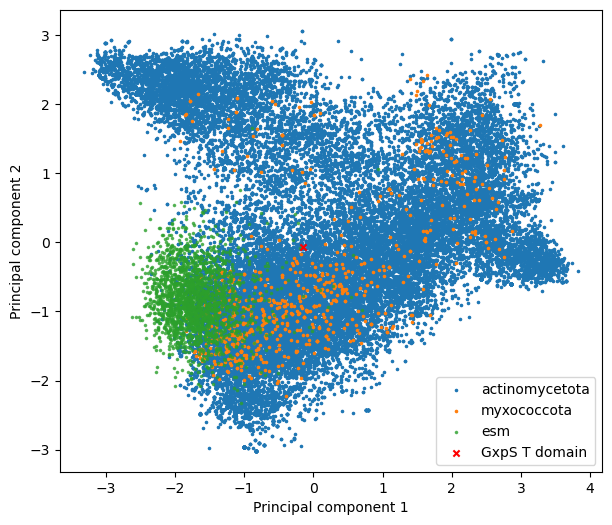

In [73]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0][mask_actinomycetota], X[:,1][mask_actinomycetota], marker='.', s=10, label='actinomycetota')
plt.scatter(X[:,0][mask_myxococcota], X[:,1][mask_myxococcota], marker='.', s=10, label='myxococcota')
plt.scatter(X[:,0][mask_esm], X[:,1][mask_esm], marker='.', s=10, label='esm', alpha=0.7)
plt.scatter(X[:,0][mask_GxpS], X[:,1][mask_GxpS], marker='x', s=20, label='GxpS T domain', c='r')
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend()
plt.show()